In [1]:
# !pip install ../pyldpc
# !pip install pyeer

In [2]:
import numpy as np
import pandas as pd
import hashlib
import random
import sys
sys.path.append("../")
from python_fuzzy_extractor.fuzzy_extractor import FuzzyExtractor
# from python_fuzzy_extractor.fuzzy_extractor_LDPC import FuzzyExtractorLDPC as FuzzyExtractor
from entropy import Entropy
import tqdm
from joblib import Parallel, delayed
import multiprocessing
import pickle
import itertools
from verification import computeAccuracyROC
from multiprocessing import Pool
import time
# from fuzzy_extractor import FuzzyExtractor

from pyeer.eer_info import get_eer_stats
from pyeer.report import generate_eer_report, export_error_rates
from pyeer.plot import plot_eer_stats
import matplotlib.pyplot as pyplot


In [3]:
# paramters
# enroll
total_length = 16 # length of input of fuzzy extractor, bytes, or 8 bits
#The number of bits that can be flipped in the source value and 
# still produce the same key with probability (1 - rep_err).
error_precision = 8
top_score = 64# factor of 16
blocks = int(top_score / total_length)# divide into several blocks
key_redundancy = 2 # at least 2, e.g., 2, means same key is bind to two blocks, hence increase redundancy
key_number = int(blocks / key_redundancy) # ensure propoerly defined
# key_segments is also realted to the key strength, or how many bits the key contains. 
using_max_entropy_or_random_perm = True
perm_feat = False# use perm for each user?

# Define IoM hashing

In [4]:
def genW(n,q,m):# m, hashcode length, q sub-dimentsion n data dimension
    return np.random.rand(m,n,q)

def IoMhashing(x,ws):
    para = np.shape(ws)
    hashcode = np.zeros(para[0])
    for i in range(para[0]):
        hashcode[i] = np.argmax(np.matmul(x,ws[i]))
    return hashcode
def IoM(embeddings,ws):
    emb_size = np.shape(embeddings)
    hashcodes = np.zeros((emb_size[0],np.shape(ws)[0]))
    for i in range(emb_size[0]):
        hashcodes[i][:] = IoMhashing(embeddings[i],ws).astype(int)
    return hashcodes.astype(int)
def euclidean_distance(hashcode,hashcode2):
    return np.linalg.norm(hashcode - hashcode2, axis=-1)/(np.linalg.norm(hashcode)+np.linalg.norm(hashcode2))
#  n how many numbers to choose
def nchoosek(startnum, endnum, step=1, n=1):
    c = []
    for i in itertools.combinations(range(startnum,endnum+1,step),n):
        c.append(list(i))
    return c



In [5]:
# embeddings = np.loadtxt('integerhashingcodes_embeddings_FVC2002_DB1_A_8x512.csv', dtype='int', delimiter=',')#512, binary
embeddings_kpca = np.loadtxt('data/kpca_embeddings_FVC2002_DB1.csv', dtype='float', delimiter=',')#512, binary

In [6]:
# test EER
def generateMatchingScores(embeddings):
    gen = [];
    combination = nchoosek(0,4, n=2)
    for i in range(100):
        for j in range(len(combination)):
            template1 = embeddings[(5*(i-1)+combination[j][0]),:]
            template2 = embeddings[(5*(i-1)+combination[j][1]),:]
            D=1- euclidean_distance(template1,template2)
            gen.append(D)
    imp = [];
    combination = nchoosek(0,99, n=2)
    for i in range(len(combination)):
        template1 = embeddings[(5*(combination[i][0]-1)+1),:]
        template2 = embeddings[(5*(combination[i][1]-1)+1),:]
        D=1 - euclidean_distance(template1,template2)
        imp.append(D)
    return (gen,imp)

# Perforamnce of KPCA

0.13080808080808082 %


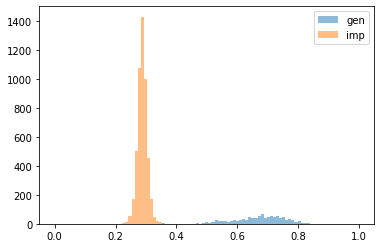

In [7]:
gen,imp = generateMatchingScores(embeddings_kpca)
stats_a = get_eer_stats(gen,imp)
print(stats_a.eer*100,'%')
# generate_eer_report([stats_a], ['A'], 'pyeer_report.csv')
plot_eer_stats([stats_a], ['A'])

bins = np.linspace(0, 1, 100)
pyplot.hist(gen, bins, alpha=0.5, label='gen')
pyplot.hist(imp, bins, alpha=0.5, label='imp')
pyplot.legend(loc='upper right')


# Performance of IoM

0.7939393939393941 %


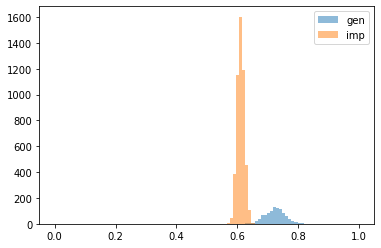

In [8]:
num_user, dx = np.shape(embeddings_kpca)
W = genW(dx,8,512)
embeddings_iom = IoM(embeddings_kpca,W)

gen,imp = generateMatchingScores(embeddings_iom)
stats_a = get_eer_stats(gen,imp)
print(stats_a.eer*100,'%')
# generate_eer_report([stats_a], ['A'], 'pyeer_report.csv')
plot_eer_stats([stats_a], ['A'])

bins = np.linspace(0, 1, 100)
pyplot.hist(gen, bins, alpha=0.5, label='gen')
pyplot.hist(imp, bins, alpha=0.5, label='imp')
pyplot.legend(loc='upper right')


In [9]:
extractor = FuzzyExtractor(total_length, error_precision)

# For each user, generate mask from first 3 samples

In [10]:
mess_len = embeddings_iom.shape[1]
masks=[]
for i in tqdm.tqdm(range(100)):
    samples = embeddings_iom[i*5:i*5+3,:]
    entropy_scores = []
    for i in range(mess_len):
        entropy_scores.append(Entropy(samples[:,i]))
    entropy_scores_sort_idx = np.argsort(entropy_scores)
    if using_max_entropy_or_random_perm:
        remain_idx =np.array(entropy_scores_sort_idx, dtype=np.uint8)
    else:
        remain_idx =np.random.permutation(range(512))# if randomly generate index?
    masks.append(remain_idx)

100%|██████████| 100/100 [00:21<00:00,  4.59it/s]


# what if we add some permutation? User-specific?

In [11]:
perms=[]
for i in tqdm.tqdm(range(100)):
    perms.append(np.random.permutation(range(top_score)))


100%|██████████| 100/100 [00:00<00:00, 37435.77it/s]


# 4th samples as enrollment template, 5 as testing

In [12]:
def randomExclude(n):
    while True:
        tmp = np.random.randint(0, 100, size=1)[0]
        if tmp!=n:
            break
    return tmp

flg=1# debug,one element 


def sub_enroll(i):
    keys= []
    helpers = []
    samples = embeddings_iom[i*5+3,:]
    mask = masks[i][:top_score]
    samples_masked = samples[mask]
    
    keys4user = []
    for ki in range(key_number):
        keys4user.append(extractor.generateKey())
    # perm the hash codes
    if perm_feat:
        samples_masked = samples_masked[perms[i]]
#     print("processing ",i)
    for starti in range(blocks):
        s = samples_masked[starti*total_length:(starti+1)*total_length]
        # fuzzy extractor
#         key, helper = extractor.generate(s)
        key, helper = extractor.generateWithPreGeneratedkey(s,keys4user[int(starti/key_number)])# be careful
        keys.append(key)
        helpers.append(helper)
    print("processing over ",i)
    return keys,helpers



In [13]:
# enroll
pool = Pool(processes = 12)
start_time=time.perf_counter()
results = []
for i in range(100):
    # 维持执行的进程总数为processes，当一个进程执行完毕后会添加新的进程进去
    r1 = pool.apply_async(sub_enroll, args=(i, ))    
    results.append(r1)
print('======  apply_async  ======')
pool.close()
#调用join之前，先调用close函数，否则会出错。执行完close后不会有新的进程加入到pool,join函数等待所有子进程结束
pool.join()


keys= []
helpers = []
    
for i in range(100):
    ikeys,ihelpers = results[i].get(timeout=5000)
    keys.append(ikeys)
    helpers.append(ihelpers)

end_time=time.perf_counter()
    
print(f"Total time of Thread execution {round(end_time- start_time,4)} for the function ")


======  apply_async  ======
processing over  7
processing over processing over   9processing over 5 11

processing over processing over processing over 
  410processing over  0
 
processing over 6

 1
processing over 
 3processing over  8
processing over  2
processing over  12
processing over  13processing over  
14
processing over processing over processing over processing over processing over     1520processing over  19 
1816

17

processing over 
21 processing over 
 23
processing over  22
processing over  24
processing over  25
processing over  processing over  2629processing over 

 27processing over processing over 
  33
28
processing over  31
processing over processing over  34
 30processing over processing over 
 32 
35
processing over  36
processing over  37
processing over processing over  39 
40
processing over  38
processing over  42processing over 
 41
processing over processing over  processing over  47processing over   4443


46
processing over  45
processing over  48
pr

# Query and test

In [14]:
# np.savez('masks.npy',masks)
# np.savez('keys.npy',keys)
# np.savez('embeddings.npy',embeddings)


# Check the key length


In [15]:
# for LDPC
print(np.shape(keys))
print(len(keys[0][0]),'bits per key')

# for w/o LDPC
print(np.shape(keys))
print(len(keys[0][0]*8),'bits per key')

(100, 4)
16 bits per key
(100, 4)
128 bits per key


In [16]:
def save_variable(v,filename):
    f=open(filename,'wb')
    pickle.dump(v,f)
    f.close()
    return filename

def load_variavle(filename):
   f=open(filename,'rb')
   r=pickle.load(f)
   f.close()
   return r

# filename = save_variable(helpers,'helpers.txt')
# results = load_variavle('helpers.txt')
#################################
def sub_repro_imposter(i):
    j = randomExclude(i)# imposter, random one
    samples = embeddings_iom[j*5+4,:]## using imposter biometric data
    mask = masks[j][:top_score]
    samples_masked = samples[mask]
#     samples_masked = np.array([binary_to_decimal(samples_masked[idx*8:(idx+1)*8]) for idx in range(16)])
    key = keys[i]
    helper = helpers[i]
    keys4usermatched = np.zeros(key_number)# indicator of key matching
    # perm the hash codes
    if perm_feat:
        samples_masked = samples_masked[perms[i]]
    positive_num=0
    for starti in range(blocks):
        p = samples_masked[starti*total_length:(starti+1)*total_length]
        # fuzzy extractor reproduce
        r_key = extractor.reproduce(p, helper[starti])  # r_key will probably still equal key!
        if r_key and r_key==key[starti]:
            keys4usermatched[int(starti/key_number)] = 1
    return positive_num

def sub_repro_imposter_disclosure_mask(i):
    j = randomExclude(i)# imposter, random one
    samples = embeddings_iom[j*5+4,:]## using imposter biometric data
    mask = masks[i][:top_score]
    samples_masked = samples[mask]
    key = keys[i]
    helper = helpers[i]
    keys4usermatched = np.zeros(key_number)# indicator of key matching
    # perm the hash codes
    if perm_feat:
        samples_masked = samples_masked[perms[j]]
    positive_num=0
    for starti in range(blocks):
        p = samples_masked[starti*total_length:(starti+1)*total_length]
        # fuzzy extractor reproduce
        r_key = extractor.reproduce(p, helper[starti])  # r_key will probably still equal key!
        if r_key and r_key==key[starti]:
            keys4usermatched[int(starti/key_number)] = 1
    return positive_num


def sub_repro_genuine(i):
    samples = embeddings_iom[i*5+4,:]
    mask = masks[i][:top_score]
    samples_masked = samples[mask]

    key = keys[i]
    helper = helpers[i]
    keys4usermatched = np.zeros(key_number)# indicator of key matching
    
    if perm_feat:
        samples_masked = samples_masked[perms[i]]
    positive_num=0
    for starti in range(blocks):        
        p = samples_masked[starti*total_length:(starti+1)*total_length]
        # fuzzy extractor reproduce
        r_key = extractor.reproduce(p, helper[starti])  # r_key will probably still equal key!
#         print('***********************************************')
#         print('++++',r_key,key[starti],'******',starti)
        if r_key and r_key==key[starti]:
            keys4usermatched[int(starti/key_number)] = 1
#             positive_num = positive_num+1
#         if r_key == None:
#             continue
#         elif abs(np.subtract(r_key, key[starti])).sum() == 0:#r_key==key[starti]
#             positive_num = positive_num+1
# #     print('process',i,positive_num)
    if np.sum(keys4usermatched) == key_number:
        positive_num = 1
    return positive_num

In [17]:
# query
#lets try 7th with mated
positive_nums=[]

pool = Pool(processes = 12)
start_time=time.perf_counter()
results = []
for i in range(100):
    # 维持执行的进程总数为processes，当一个进程执行完毕后会添加新的进程进去
    r1 = pool.apply_async(sub_repro_genuine, args=(i, ))    
    results.append(r1)
print('======  apply_async  ======')
pool.close()
#调用join之前，先调用close函数，否则会出错。执行完close后不会有新的进程加入到pool,join函数等待所有子进程结束
pool.join()


for i in range(100):
    positive_nums.append(results[i].get(timeout=100))

end_time=time.perf_counter()
    
print(f"Total time of Thread execution {round(end_time- start_time,4)} for the function ")
# print(positive_nums)


======  apply_async  ======
Total time of Thread execution 18.8743 for the function 


In [18]:
print(sum(np.array(positive_nums)>0)/len(positive_nums))
# positive_nums 93% w/o ldpc  94% wLDPC

0.93


# imposter

## imposter knows 

In [19]:
false_positive_nums = []
pool = Pool(processes = 10)
start_time=time.perf_counter()
results = []
for i in range(100):
    # 维持执行的进程总数为processes，当一个进程执行完毕后会添加新的进程进去
    r1 = pool.apply_async(sub_repro_imposter, args=(i, ))    
    results.append(r1)
print('======  apply_async  ======')
pool.close()
#调用join之前，先调用close函数，否则会出错。执行完close后不会有新的进程加入到pool,join函数等待所有子进程结束
pool.join()


for i in range(100):
    false_positive_nums.append(results[i].get(timeout=1000))

end_time=time.perf_counter()
    
print(f"Total time of Thread execution {round(end_time- start_time,4)} for the function ")


======  apply_async  ======
Total time of Thread execution 22.4374 for the function 


In [20]:
false_positive_nums_same_mask = []
pool = Pool(processes = 12)
start_time=time.perf_counter()
results = []
for i in range(100):
    # 维持执行的进程总数为processes，当一个进程执行完毕后会添加新的进程进去
    r1 = pool.apply_async(sub_repro_imposter_disclosure_mask, args=(i, ))    
    results.append(r1)
print('======  apply_async  ======')
pool.close()
#调用join之前，先调用close函数，否则会出错。执行完close后不会有新的进程加入到pool,join函数等待所有子进程结束
pool.join()


for i in range(100):
    false_positive_nums_same_mask.append(results[i].get(timeout=1000))

end_time=time.perf_counter()
    
print(f"Total time of Thread execution {round(end_time- start_time,4)} for the function ")


======  apply_async  ======
Total time of Thread execution 22.5364 for the function 


In [21]:
print(positive_nums)
# print(false_positive_nums)
print(false_positive_nums_same_mask)
print(false_positive_nums)
print('blocks',blocks)
# print(false_positive_nums2)
threshold1 = 1
threshold2 = 1
# threshold = 1
print('threshold1:',threshold1)
print('threshold2:',threshold2)
positive_nums = np.array(positive_nums)
# false_positive_nums = np.array(false_positive_nums)
false_positive_nums = np.array(false_positive_nums)
false_positive_nums_same_mask = np.array(false_positive_nums_same_mask)

## 
tpr = sum(positive_nums>=threshold1)/len(positive_nums)
fpr = sum(false_positive_nums>=threshold1)/len(false_positive_nums)

print('tpr,fpr',tpr,fpr)

## 
tpr = sum(positive_nums>=threshold2)/len(positive_nums)
fpr_same_mask = sum(false_positive_nums_same_mask>=threshold2)/len(false_positive_nums_same_mask)

print('tpr,fpr_samemask',tpr,fpr_same_mask)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
blocks 4
threshold1: 1
threshold2: 1
tpr,fpr 0.93 0.0
tpr,fpr_samemask 0.93 0.0


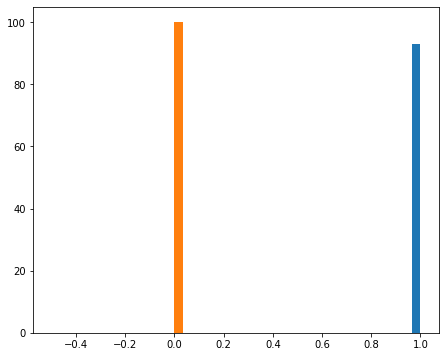

In [22]:
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,6)) #创建幕布
ax = fig.add_subplot(121) #截取幕布的一部分，121是简写，表示1行2列中的第1个图
ns,edgeBin,patches = plt.hist(positive_nums,bins=30,rwidth=1)
ns,edgeBin,patches = plt.hist(false_positive_nums,bins=30,rwidth=1)


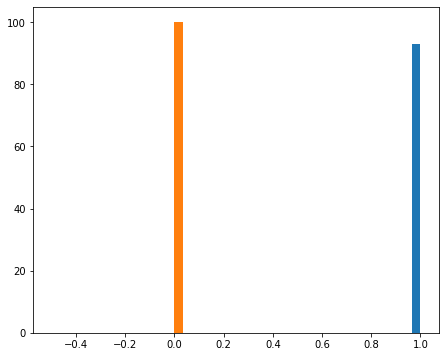

In [23]:
fig = plt.figure(figsize=(16,6)) #创建幕布
ax = fig.add_subplot(121) #截取幕布的一部分，121是简写，表示1行2列中的第1个图
ns,edgeBin,patchesshape = plt.hist(positive_nums,bins=30,rwidth=1)
ns,edgeBin,patches = plt.hist(false_positive_nums_same_mask,bins=30,rwidth=1)


# result 0FAR
